In [95]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns
sns.set_theme(style="whitegrid")


# THESE LINES FORCE CPU USAGE.
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = '-1'

import keras
from keras.models import Sequential
from keras.layers import Dense, Embedding
from tensorflow.python.client import device_lib
from keras_transformer import get_model, get_custom_objects
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras_transformer import decode

In [59]:
plt.rcParams['figure.dpi']= 150


In [2]:
# different environments may not correctly have a working dir. Change this line as appropriate
path_to_data = r"./data/winemag-data-130k-v2.csv"
# path_to_data = r"./data/winemag-data-130k-v2_lemma.csv"
df = pd.read_csv(path_to_data)
df = df.drop(columns=['Unnamed: 0'])


In [3]:
def clean_category(col_choice,data,threshold=99999999):
    reduce_in = data[col_choice].value_counts()[:threshold]
    data[col_choice] = np.where(data[col_choice].isin(reduce_in.index), data[col_choice], "other")


In [28]:
# Generate dictionaries
def build_token_dict(token_list):
    token_dict = {
        '<PAD>': 0,
        '<START>': 1,
        '<END>': 2,
    }
    for tokens in token_list:
        for token in tokens:
            if token not in token_dict:
                token_dict[token] = len(token_dict)
    return token_dict


In [46]:
filtered = df[['description', 'variety']].copy()
filtered = filtered[filtered.description.str.len() > 20]
clean_category('variety', filtered, 9999)
filtered['variety'].value_counts()
random = 13272 / 116691
random


0.11373627786204592

In [84]:
inc = 999_000

source_tokens = []
for desc in filtered['description'][:inc]:
    source_tokens.append(desc.split(' '))



In [85]:
target_tokens = []

for variety in filtered['variety'][:inc]:
    target_tokens.append(variety.split(' '))


In [86]:
source_token_dict = build_token_dict(source_tokens)
target_token_dict = build_token_dict(target_tokens)
target_token_dict_inv = {v: k for k, v in target_token_dict.items()}


# Add special tokens
encode_tokens = [['<START>'] + tokens + ['<END>'] for tokens in source_tokens]
decode_tokens = [['<START>'] + tokens + ['<END>'] for tokens in target_tokens]
output_tokens = [tokens + ['<END>', '<PAD>'] for tokens in target_tokens]

# Padding
source_max_len = max(map(len, encode_tokens))
target_max_len = max(map(len, decode_tokens))

encode_tokens = [tokens + ['<PAD>'] * (source_max_len - len(tokens)) for tokens in encode_tokens]
decode_tokens = [tokens + ['<PAD>'] * (target_max_len - len(tokens)) for tokens in decode_tokens]
output_tokens = [tokens + ['<PAD>'] * (target_max_len - len(tokens)) for tokens in output_tokens]

encode_input = [list(map(lambda x: source_token_dict[x], tokens)) for tokens in encode_tokens]
decode_input = [list(map(lambda x: target_token_dict[x], tokens)) for tokens in decode_tokens]
decode_output = [list(map(lambda x: [target_token_dict[x]], tokens)) for tokens in output_tokens]

In [33]:
# split into test and train

ab = pd.concat([pd.Series(encode_input), pd.Series(decode_input)], axis=1)
x_train, x_test, y_train, y_test = train_test_split(ab, decode_output, test_size=.05)


x_train_encode_input =x_train[0].to_list()
x_train_decode_input =x_train[1].to_list()
x_test_encode_input = x_test[0].to_list()
x_test_decode_input = x_test[1].to_list()

In [47]:
# Build & fit model
model = get_model(
    token_num=max(len(source_token_dict), len(target_token_dict)),
    embed_dim=64,
    encoder_num=4,
    decoder_num=2,
    head_num=8,
    hidden_dim=256, # Needs to be much larger
    dropout_rate=0.1, #Dropout .1
    use_same_embed=False,  # Use different embeddings for different languages
)
model.compile('adam', 'sparse_categorical_crossentropy')
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Encoder-Input (InputLayer)      (None, None)         0                                            
__________________________________________________________________________________________________
Encoder-Token-Embedding (Embedd [(None, None, 64), ( 5011264     Encoder-Input[0][0]              
__________________________________________________________________________________________________
Encoder-Embedding (TrigPosEmbed (None, None, 64)     0           Encoder-Token-Embedding[0][0]    
__________________________________________________________________________________________________
Encoder-1-MultiHeadSelfAttentio (None, None, 64)     16640       Encoder-Embedding[0][0]          
____________________________________________________________________________________________

In [35]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

In [36]:
history = LossHistory()
model.fit(
    x=[np.array(x_train_encode_input * 1), np.array(x_train_decode_input * 1)],
    y=np.array(y_train* 1 ),
    epochs=6,
    batch_size=128,
    callbacks=[history]
)

model.save(r"C:\Users\cburg\Documents\wine\model")

E:\anaconda\envs\keras37\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
E:\anaconda\envs\keras37\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/6
123471/123471 [==============================] - 328s 3ms/step - loss: 0.9288

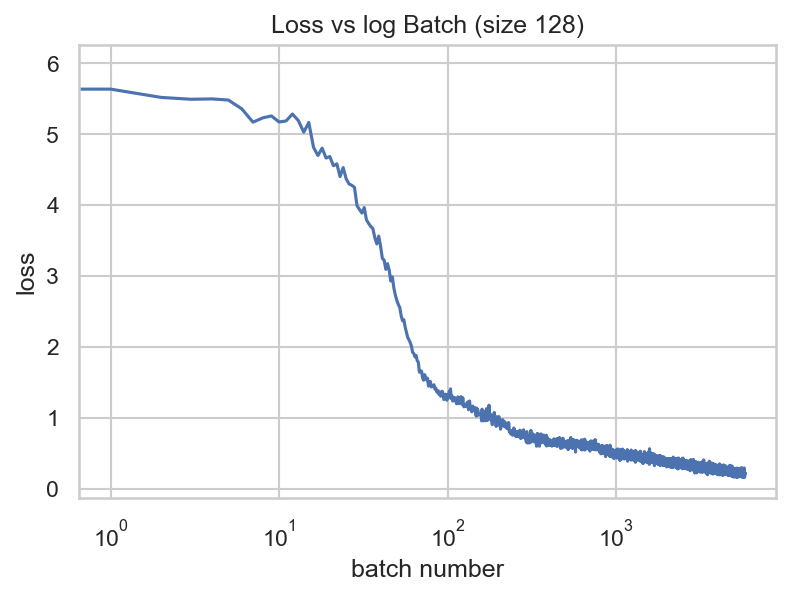

In [60]:
ax = sns.lineplot(y=history.losses, x=np.arange(len(history.losses)))
ax.set(xlabel='batch number', ylabel='loss', xscale='log', title='Loss vs log Batch (size 128)')
ax.get_figure().savefig(r"C:\Users\cburg\Documents\wine\training.png")

In [48]:
model.save(r"C:\Users\cburg\Documents\wine\model")
# print(len(x_test_encode_input))

In [96]:
model2 = keras.models.load_model(r"C:\Users\cburg\Documents\wine\5482", custom_objects=get_custom_objects())

E:\anaconda\envs\keras37\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
E:\anaconda\envs\keras37\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [181]:
# Predict

#predict top examples
top = 15
decoded = decode(
    model2,
    x_test_encode_input[:top],
    top_k=5,
    start_token=target_token_dict['<START>'],
    end_token=target_token_dict['<END>'],
    pad_token=target_token_dict['<PAD>'],
)

# print(' '.join(map(lambda x: target_token_dict_inv[x], decoded[0][1:-1])))
# print(' '.join(map(lambda x: target_token_dict_inv[x], decoded[1][1:-1])))

In [126]:
print(len(decoded))
print(target_token_dict_inv[1])
source_token_dict_inv = {v: k for k, v in source_token_dict.items()}

15
<START>


In [182]:
idx = 0
correct = 0
pino_guesses = 0

predictions = []
actual = []
descriptions = []
# print(decoded)
for pred in decoded:
    if len(pred) > 2:
        # print(idx)
        y_pred = (' '.join(map(lambda x: target_token_dict_inv[x] if x not in [0, 1, 2] else '', pred[1:-1])))
        y = (' '.join(map(lambda x: target_token_dict_inv[x[0]] if x[0] not in [0, 1, 2] else '', list(y_test[idx]))))
        y_pred = y_pred.strip()
        y = y.strip()

        if False:
            predictions.append(y_pred)
            actual.append(y)
            src = x_test_encode_input[idx]
            src = (' '.join(map(lambda x: source_token_dict_inv[x] if x not in [0, 1, 2] else '', src)))
            descriptions.append(src)

        print(y_pred)
        print(y)
        yps = y_pred.split(' ')
        ys = y.split(' ')
        if y_pred == "Pinot Noir":
            pino_guesses += 1
        if y_pred == y:
        # if any(x in yps for x in ys):
            correct +=1

    idx += 1
print(correct/idx)
print(pino_guesses/idx)

Cabernet
Red Blend
Malbec
Malbec
Red Riesling Grosso Nebbiolo  Grosso
Sangiovese
Cabernet Sauvignon Bois Bois  Blend Blend Blend Blend Blanc
Red Blend
Red Blend
Aglianico
Turbiana Spoletino
Garganega
Rhône-style Syrah
Shiraz
Champagne Blanc
Sparkling Blend
Melon
Chardonnay
Meritage
Red Blend
Rosé Blend
Rosé
Cabernet Sauvignon-Carmenère Bois Blend
Cabernet Sauvignon
Moscato
Pinot Nero
Rosé
Merlot
Pinot Noir Bois  Noir Blend  Bois
Cabernet Sauvignon
0.06666666666666667
0.0


In [128]:
# print(np.array([descriptions, actual, predictions], axis=1))
a = pd.Series(descriptions)
b = pd.Series(actual)
c = pd.Series(predictions)
examples = pd.concat([a, b, c], axis=1)
examples.columns = ["Description", "Actual Variety", "Predicted Variety"]
examples

# examples = pd.DataFrame(data=[descriptions, actual, predictions], columns=["desc", "ac", "gues"])
# examples.head()
# MODEL COMES UP WITH COOL TYPES OF WINE

# report exact matches
# report word in word
# report word in word topk

,Description,Actual Variety,Predicted Variety
0,Made with Sangiovese and a touch of Colorino ...,Red Blend,Red Blend
1,"Campfire, animal, horseradish and berry aroma...",Malbec,Malbec
2,"Scorched earth, toasted nut, espresso, cured ...",Sangiovese,Sangiovese
3,"Here's a soft, fruity and sweet Cabernet, ric...",Red Blend,Cabernet Sauvignon
4,"Aromas of coconut, espresso and spiced plum s...",Aglianico,Red Blend
5,"Bright, generous and straightforward, Soave C...",Garganega,Garganega
6,"Deep violet red to the eye, this wine offers ...",Shiraz,Rhône-style Red Blend
7,"Apple and citrus notes signal freshness, with...",Sparkling Blend,Pinot Gris
8,"This ripe, smoothly textured wine is rich wit...",Chardonnay,Chardonnay
9,"Bold, ripe fruit and chocolate notes open the...",Red Blend,Bordeaux-style Red Blend


In [140]:
with pd.option_context("max_colwidth", 200):
    print(examples.to_latex(index=False, column_format='p{10cm}|p{2.5cm}|p{2.5cm}', multirow=True))

\begin{tabular}{p{10cm}|p{2.5cm}|p{2.5cm}}
\toprule
                                                                                                                                                                                             Description &      Actual Variety &         Predicted Variety \\
\midrule
  Made with Sangiovese and a touch of Colorino and Canaiolo, this easygoing wine offers pretty aromas of violet and red cherry. The soft, enjoyable palate doles out crushed raspberry, clove and a t... &           Red Blend &                 Red Blend \\
  Campfire, animal, horseradish and berry aromas make for a slightly difficult nose. This Malbec feels pinched, with tannic pull. Salty black-fruit flavors finish similar, with popping acidity that... &              Malbec &                    Malbec \\
  Scorched earth, toasted nut, espresso, cured meat and baked plum aromas lead the nose on this concentrated wine along with a hint of new leather. The big, chewy palate doles o

In [180]:
f_c = filtered.copy()
clean_category('variety', f_c, 10)
res = f_c['variety'].value_counts(normalize=True).mul(100).round(1)
res = pd.concat([pd.Series(res.index.tolist()),
           pd.Series(res.tolist())], axis=1)
res.columns = ["variety", "% of dataset"]


print(res.to_latex(index=False))

\begin{tabular}{lr}
\toprule
                  variety &  \% of dataset \\
\midrule
                    other &          45.1 \\
               Pinot Noir &          10.2 \\
               Chardonnay &           9.0 \\
       Cabernet Sauvignon &           7.3 \\
                Red Blend &           6.9 \\
 Bordeaux-style Red Blend &           5.3 \\
                 Riesling &           4.0 \\
          Sauvignon Blanc &           3.8 \\
                    Syrah &           3.2 \\
                     Rosé &           2.7 \\
                   Merlot &           2.4 \\
\bottomrule
\end{tabular}

